In [ ]:
Objective 2: Supervised Regression
Goal: Predict a specific numerical outcome (in this case, AmountDue).

Method: We used Linear Regression to train a model on historical data, where the model learns the relationship between 
various features (like total liabilities, equity, etc.) and the target variable (AmountDue).

Output: The model predicts a continuous value, in this case, the amount of money Monoprix will owe for a given 
supplier. It provides specific predictions rather than groups.
Predicts the specific amount due based on financial metrics, supplier data, and dispute information, 
providing actionable insights for financial decision-making.
In this case, we want to predict how much will be owed (or due) based on various inputs, rather than classifying items into groups.

In [8]:
import pyodbc
import pandas as pd

# Set your credentials here
server = 'DESKTOP-MFO02KK'  # or your instance name
database = 'DW_Finance'  # or the actual DB name
username = 'nesrine'  # if using SQL Server Authentication
password = 'nesrine'

# Use this if you're using SQL Server Authentication
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password}'
)

conn = pyodbc.connect(conn_str)



C:\Users\bouss\AppData\Local\Temp\ipykernel_9648\1336282323.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


📈 Correlations with AmountDue:
 AmountDue               1.000000
BalanceDue              0.637694
AmountPaid              0.636332
Fk_Date                 0.039619
Equity                  0.017786
TotalAssets             0.017206
ActualExpenses          0.013019
Budget                  0.004714
Fk_Grand_Livre          0.003854
TotalLiabilities       -0.004507
DisputeStatus_Ouvert   -0.005703
Fk_Supplier            -0.011509
Name: AmountDue, dtype: float64
🚫 Dropping highly correlated features: []
✅ Mean Squared Error: 0.01
✅ R-squared: 1.00


C:\Users\bouss\AppData\Local\Temp\ipykernel_9648\1336282323.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bouss\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


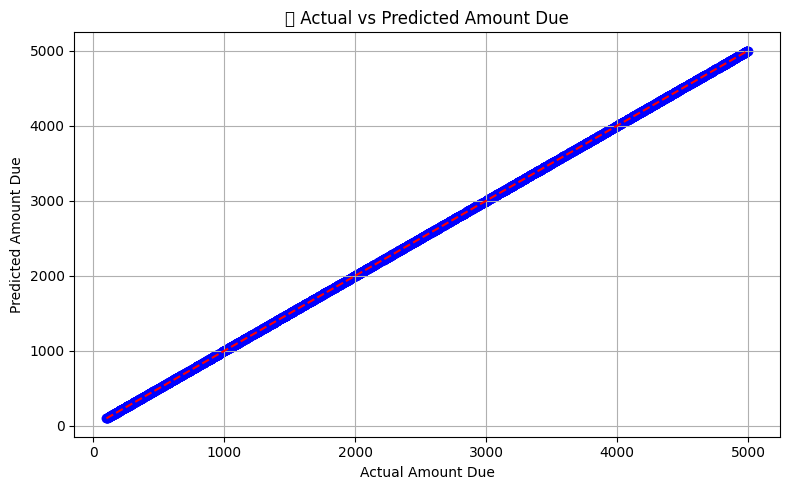

📌 Predicted Amount Due for new supplier data: 0.12


In [9]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# SQL Query
query = """
SELECT 
    fs.AmountDue,
    fs.AmountPaid,
    fs.BalanceDue,
    fs.TotalAssets,
    fs.TotalLiabilities,
    fs.Equity,
    fs.ActualExpenses,
    fs.Budget,
    fs.Fk_Supplier,
    fs.Fk_Date,
    fs.Fk_Grand_Livre,
    d.Status AS DisputeStatus
FROM 
    fact_Financial_Situation fs
JOIN 
    dim_disputes d ON fs.Fk_Disputes = d.Pk_Disputes
"""

# Load data
df = pd.read_sql(query, conn)

# Preprocessing
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Encode categorical
df = pd.get_dummies(df, columns=['DisputeStatus'], drop_first=True)

# ✅ Check correlation
correlations = df.corr()['AmountDue'].sort_values(ascending=False)
print("📈 Correlations with AmountDue:\n", correlations)

# ✅ Drop highly correlated features (if correlation > 0.95)
features_to_drop = []
for feature, corr in correlations.items():
    if abs(corr) > 0.95 and feature != 'AmountDue':
        features_to_drop.append(feature)

print(f"🚫 Dropping highly correlated features: {features_to_drop}")

# Features and target
X = df.drop(['AmountDue'] + features_to_drop, axis=1)
y = df['AmountDue']

# ✅ Data augmentation (simple noise addition)
def augment_data(X, y, noise_level=0.05, num_copies=3):
    X_augmented = X.copy()
    y_augmented = y.copy()
    
    for _ in range(num_copies):
        noise = np.random.normal(0, noise_level, size=X.shape)
        X_noisy = X + noise
        X_augmented = pd.concat([X_augmented, pd.DataFrame(X_noisy, columns=X.columns)], axis=0)
        y_augmented = pd.concat([y_augmented, y], axis=0)
    
    return X_augmented, y_augmented

X_aug, y_aug = augment_data(X, y, noise_level=0.05, num_copies=3)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)

# ✅ Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Train model (Ridge Regression for regularization)
model = Ridge(alpha=1.0, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'✅ Mean Squared Error: {mse:.2f}')
print(f'✅ R-squared: {r2:.2f}')

# Plot actual vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Amount Due')
plt.ylabel('Predicted Amount Due')
plt.title('📊 Actual vs Predicted Amount Due')
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Predict on new test data (example)
new_data = pd.DataFrame([{
    'TotalAssets': 100000,
    'TotalLiabilities': 50000,
    'Equity': 50000,
    'ActualExpenses': 30000,
    'Budget': 35000,
    'Fk_Supplier': 2,
    'Fk_Date': 25,
    'Fk_Grand_Livre': 7,
    'DisputeStatus_Open': 1  # If other dummy columns exist, set appropriately
}])

# Align new data columns with training set
new_data = new_data.reindex(columns=X.columns, fill_value=0)
new_data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)
print(f"📌 Predicted Amount Due for new supplier data: {prediction[0]:.2f}")

# Close connection
conn.close()


C:\Users\bouss\AppData\Local\Temp\ipykernel_10076\2602086441.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Mean Squared Error: 0.00
✅ R-squared: 1.00


C:\Users\bouss\AppData\Local\Temp\ipykernel_10076\2602086441.py:74: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bouss\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


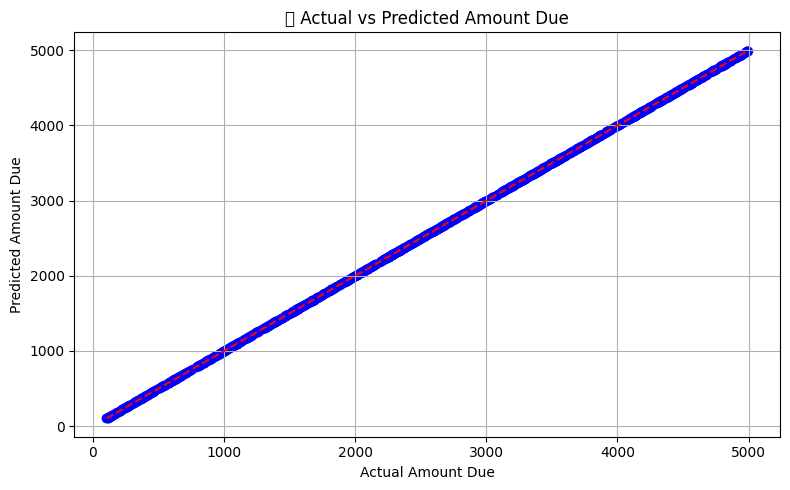

📌 Predicted Amount Due for new supplier data: 45000.00


In [3]:
#updated code
import pyodbc 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# SQL Query
query = """
SELECT 
    fs.AmountDue,
    fs.AmountPaid,
    fs.BalanceDue,
    fs.TotalAssets,
    fs.TotalLiabilities,
    fs.Equity,
    fs.ActualExpenses,
    fs.Budget,
    fs.Fk_Supplier,
    fs.Fk_Date,
    fs.Fk_Grand_Livre,
    d.Status AS DisputeStatus
FROM 
    fact_Financial_Situation fs
JOIN 
    dim_disputes d ON fs.Fk_Disputes = d.Pk_Disputes
"""

# Load data
df = pd.read_sql(query, conn)

# Preprocessing
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Encode categorical
df = pd.get_dummies(df, columns=['DisputeStatus'], drop_first=True)

# Features and target
X = df.drop(['AmountDue'], axis=1)
y = df['AmountDue']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'✅ Mean Squared Error: {mse:.2f}')
print(f'✅ R-squared: {r2:.2f}')

# Plot actual vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Amount Due')
plt.ylabel('Predicted Amount Due')
plt.title('📊 Actual vs Predicted Amount Due')
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Predict on new test data (example)
new_data = pd.DataFrame([{
    'AmountPaid': 40000,
    'BalanceDue': 5000,
    'TotalAssets': 100000,
    'TotalLiabilities': 50000,
    'Equity': 50000,
    'ActualExpenses': 30000,
    'Budget': 35000,
    'Fk_Supplier': 2,
    'Fk_Date': 25,
    'Fk_Grand_Livre': 7,
    'DisputeStatus_Open': 1  # Change if another dummy column exists
}])

# Align new data columns with training set
new_data = new_data.reindex(columns=X.columns, fill_value=0)
new_data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)
print(f"📌 Predicted Amount Due for new supplier data: {prediction[0]:.2f}")


C:\Users\bouss\AppData\Local\Temp\ipykernel_12228\2522499439.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Mean Squared Error: 2.2299296451293e-18
R-squared: 1.0


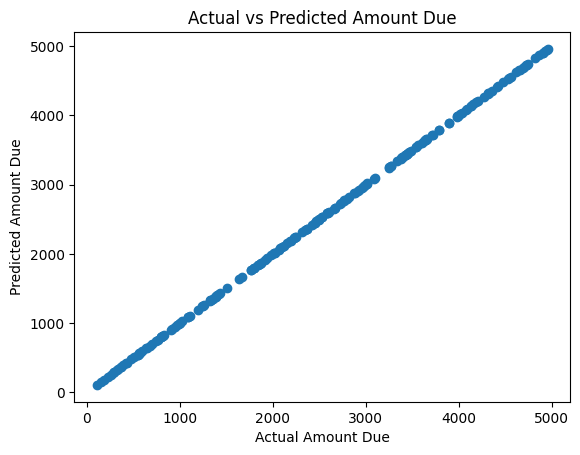

In [ ]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# SQL Query to fetch data from the relevant tables
query = """
SELECT 
    fs.AmountDue,
    fs.AmountPaid,
    fs.BalanceDue,
    fs.TotalAssets,
    fs.TotalLiabilities,
    fs.Equity,
    fs.ActualExpenses,
    fs.Budget,
    fs.Fk_Supplier,
    fs.Fk_Date,
    fs.Fk_Grand_Livre,
    d.Status AS DisputeStatus
FROM 
    fact_Financial_Situation fs
JOIN 
    dim_disputes d ON fs.Fk_Disputes = d.Pk_Disputes
"""

# Read the data into a DataFrame
df = pd.read_sql(query, conn)

# Preprocessing
# Fill missing values (if any) with the mean of the column, but only for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns  # Get only numeric columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Encode categorical variables (e.g., Dispute Status)
df = pd.get_dummies(df, columns=['DisputeStatus'], drop_first=True)

# Define feature variables (X) and target variable (y)
X = df.drop(['AmountDue'], axis=1)  # Feature variables (exclude AmountDue as it's the target)
y = df['AmountDue']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Amount Due')
plt.ylabel('Predicted Amount Due')
plt.title('Actual vs Predicted Amount Due')
plt.show()


Applying cross validation because model is too "perfect". this may be due to overfitting

C:\Users\bouss\AppData\Local\Temp\ipykernel_12228\2654418565.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Cross-validation Mean Squared Error (MSE): 3.261699430406884e-19
Cross-validation Standard Deviation: 4.573496338437706e-19
Mean Squared Error: 1.987546380261551e-18
R-squared: 1.0


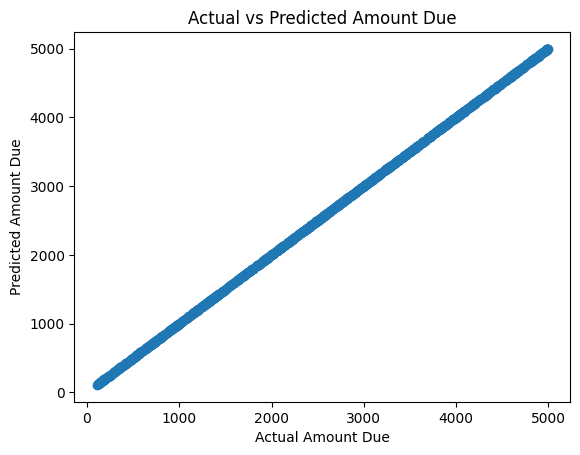

In [ ]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# SQL Query to fetch data from the relevant tables
query = """
SELECT 
    fs.AmountDue,
    fs.AmountPaid,
    fs.BalanceDue,
    fs.TotalAssets,
    fs.TotalLiabilities,
    fs.Equity,
    fs.ActualExpenses,
    fs.Budget,
    fs.Fk_Supplier,
    fs.Fk_Date,
    fs.Fk_Grand_Livre,
    d.Status AS DisputeStatus
FROM 
    fact_Financial_Situation fs
JOIN 
    dim_disputes d ON fs.Fk_Disputes = d.Pk_Disputes
"""

# Read the data into a DataFrame
df = pd.read_sql(query, conn)

# Preprocessing
# Fill missing values (if any) with the mean of the column, but only for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns  # Get only numeric columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Encode categorical variables (e.g., Dispute Status)
df = pd.get_dummies(df, columns=['DisputeStatus'], drop_first=True)

# Define feature variables (X) and target variable (y)
X = df.drop(['AmountDue'], axis=1)  # Feature variables (exclude AmountDue as it's the target)
y = df['AmountDue']  # Target variable

# Initialize the linear regression model
model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation results
print(f'Cross-validation Mean Squared Error (MSE): {-cv_scores.mean()}')
print(f'Cross-validation Standard Deviation: {cv_scores.std()}')

# Fit the model to the entire dataset and make predictions
model.fit(X, y)
y_pred = model.predict(X)

# Evaluate the model on the entire dataset
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the actual vs predicted values
plt.scatter(y, y_pred)
plt.xlabel('Actual Amount Due')
plt.ylabel('Predicted Amount Due')
plt.title('Actual vs Predicted Amount Due')
plt.show()


Cross-validation Mean Squared Error (MSE): 3.2799778005367803e-12
Cross-validation Standard Deviation: 1.423089902708273e-13
Mean Squared Error: 2.0343105695778117e-12
R-squared: 1.0


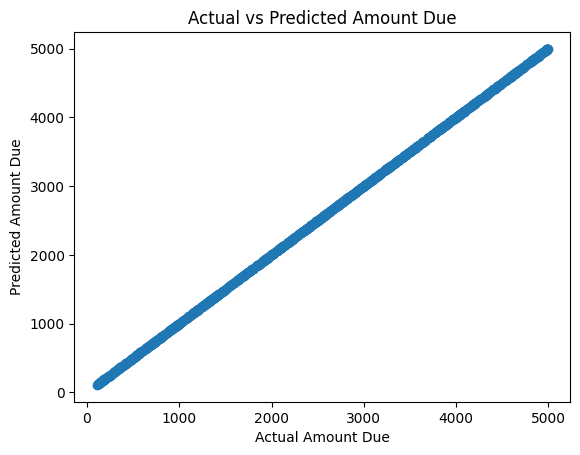

In [4]:
from sklearn.linear_model import Ridge

# Initialize the Ridge regression model
model = Ridge(alpha=1.0)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation results
print(f'Cross-validation Mean Squared Error (MSE): {-cv_scores.mean()}')
print(f'Cross-validation Standard Deviation: {cv_scores.std()}')

# Fit the model to the entire dataset and make predictions
model.fit(X, y)
y_pred = model.predict(X)

# Evaluate the model on the entire dataset
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the actual vs predicted values
plt.scatter(y, y_pred)
plt.xlabel('Actual Amount Due')
plt.ylabel('Predicted Amount Due')
plt.title('Actual vs Predicted Amount Due')
plt.show()
